In [1]:
%env SM_FRAMEWORK=tf.keras
import zipfile, os, numpy as np, pickle, yaml, gc, tensorflow as tf
import segmentation_models as sm
import tensorflow_addons as tfa
sys.path.append("..")
from model.resnet3d import Resnet3DBuilder
from model.cnn_model import get_model
from tensorflow import keras
from keras import backend as K
K.clear_session()
from segmentation_models import Unet
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
def load_config(config_name):
    with open(config_name) as file:
        config = yaml.safe_load(file)
    return config
config = load_config("utils/model_config.yaml")
datatype='3.0T'
nii_size = config['nii_size']

S1 Testing Start!

In [3]:
# path test, train
top_layer_path = config['top_layer_path']
# S1 [img, msk]
S1_img_stack = config['S1_img_stack']
# S2 label
S2_img_stack = config['S2_img_stack']
# save path
save_path = f'results_log/compose_model/all_NL-test_results_{datatype}'

# S1 train [img, msk]
S1_img_stack_train = config['S1_img_stack_train']
# S2 train label
S2_img_stack_train = config['S2_img_stack_train']

# S1 model weight path
S1_weights=[config["S1_dense"], config["S1_res"], config["S1_vgg"]]
S1_backbone = ['densenet121', 'resnet50', 'vgg16']
# S2 model weight path
S2_weight=[config["S2_Resnet18"], config["S2_ResNet50"], config["S2_CNN"]]
S2_backbone =['resnet18', 'resnet50', 'cnn']

In [4]:
def S1_dataloader(valid_data='Mix', tune_type='test'):
    if tune_type=='test':
        img_layer_path = top_layer_path[0]
        if valid_data == '3.0T':
            # loading valida data 3.0T + 1.5T: image / masks
            X_valid = np.load(img_layer_path +'/'+ S1_img_stack[0])
            y_valid = np.load(img_layer_path +'/'+ S1_img_stack[1])

    elif tune_type=='train':
        img_layer_path = top_layer_path[1]
        # loading valida data 3.0T + 1.5T: image / masks
        X_valid = np.load(img_layer_path +'/'+ S1_img_stack_train[0])
        y_valid = np.load(img_layer_path +'/'+ S1_img_stack_train[1])

    X_valid = np.reshape(X_valid, (X_valid.shape[0]*32,384,384,1))
    y_valid = np.reshape(y_valid, (y_valid.shape[0]*32,384,384,1))
    return X_valid.astype(np.float32), y_valid.astype(np.int8)

In [5]:
def S1_model_loader(weight_path, backbone, mode):
    S1_X_valid, S1_y_valid= S1_dataloader(valid_data=datatype, tune_type=mode)
    print(f'S1 data shape: img {S1_X_valid.shape} msk {S1_y_valid.shape}')
    model = Unet(backbone, encoder_weights=None, input_shape=(None, None, 1))
    model.load_weights(weight_path)
    Results = model.predict(S1_X_valid, batch_size=1, verbose=1)
    return Results, S1_X_valid, S1_y_valid

In [6]:
def S2_model_loader(S1_pred_X, weight_path, backbone):
    if 'resnet18' in backbone:
        model = Resnet3DBuilder.build_resnet_18((32, nii_size, nii_size, 1), 1)
    elif 'resnet50' in backbone:
        model = Resnet3DBuilder.build_resnet_50((32, nii_size, nii_size, 1), 1)
    elif 'cnn' in backbone:
        model = get_model(depth=32, width=384, height=384, class_num=1, classification_layer='sigmoid')
    
    model.load_weights(weight_path)
    Results = model.predict(S1_pred_X, batch_size=1, verbose=1)
    return Results

In [8]:
import pandas as pd
if datatype=='3.0T':
    data_n = 0
S2_y_flatten = np.load(top_layer_path[0] + '/' + S2_img_stack[data_n]).flatten()
S2_model_df = pd.DataFrame(S2_y_flatten, columns=['GT'])

In [9]:
S1_thresholds = 0.5
S1_pred_stack=[]
S2_pred_stack=[]
S2_pred_stack_train=[]
# ----S1 model test 1 - 3----
mode_list=['test']
for d in mode_list:
    print(f'Start model = {d}')
    for i in range(3):
        S1_pred, S1_X_valid, S1_y_valid = S1_model_loader(S1_weights[i], S1_backbone[i], d)
        S1_pred = np.reshape(S1_pred, (S1_pred.shape[0]//32,32,384,384))
        S1_y_valid = np.reshape(S1_y_valid, (S1_y_valid.shape[0]//32,32,384,384))
        S1_X_valid = np.reshape(S1_X_valid, (S1_X_valid.shape[0]//32,32,384,384))
        S1_pred = np.where(S1_pred > S1_thresholds, S1_X_valid, S1_X_valid*0)
        S1_pred_stack.append(S1_pred)
        # ----S2 model test 1 - 3----
        for j in range(3):
            print(S1_backbone[i], S2_backbone[j])
            S2_pred = S2_model_loader(S1_pred, S2_weight[j], S2_backbone[j])
            if d=='test':
                S2_pred_stack.append(S2_pred)
                S2_model_df[f'{S1_backbone[i]} + {S2_backbone[j]}'] = S2_pred.flatten()
        del S1_pred, S2_pred


Start model = test
S1 data shape: img (1440, 384, 384, 1) msk (1440, 384, 384, 1)
1440/1440 [==============================] - 32s 22ms/step
densenet121 resnet18
45/45 [==============================] - 2s 48ms/step
densenet121 resnet50
45/45 [==============================] - 3s 70ms/step
densenet121 cnn
45/45 [==============================] - 2s 55ms/step
S1 data shape: img (1440, 384, 384, 1) msk (1440, 384, 384, 1)
1440/1440 [==============================] - 25s 17ms/step
resnet50 resnet18
45/45 [==============================] - 2s 49ms/step
resnet50 resnet50
45/45 [==============================] - 3s 70ms/step
resnet50 cnn
45/45 [==============================] - 3s 57ms/step
S1 data shape: img (1440, 384, 384, 1) msk (1440, 384, 384, 1)
1440/1440 [==============================] - 23s 16ms/step
vgg16 resnet18
45/45 [==============================] - 2s 49ms/step
vgg16 resnet50
45/45 [==============================] - 3s 69ms/step
vgg16 cnn
45/45 [=============================

In [10]:
S2_model_df.to_csv(f'NL {datatype} all model.csv',index=0)

In [11]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, auc, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

In [13]:
from scipy.stats import sem
sys.path.append("..")
from utils.visual_plt import ClassReport
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
def CI(y_pred, y_true, optimal_th, score_type):
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        if score_type=='acc':
            score = accuracy_score(y_true[indices], y_pred[indices]>optimal_th)
        elif score_type=='auc':
            score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

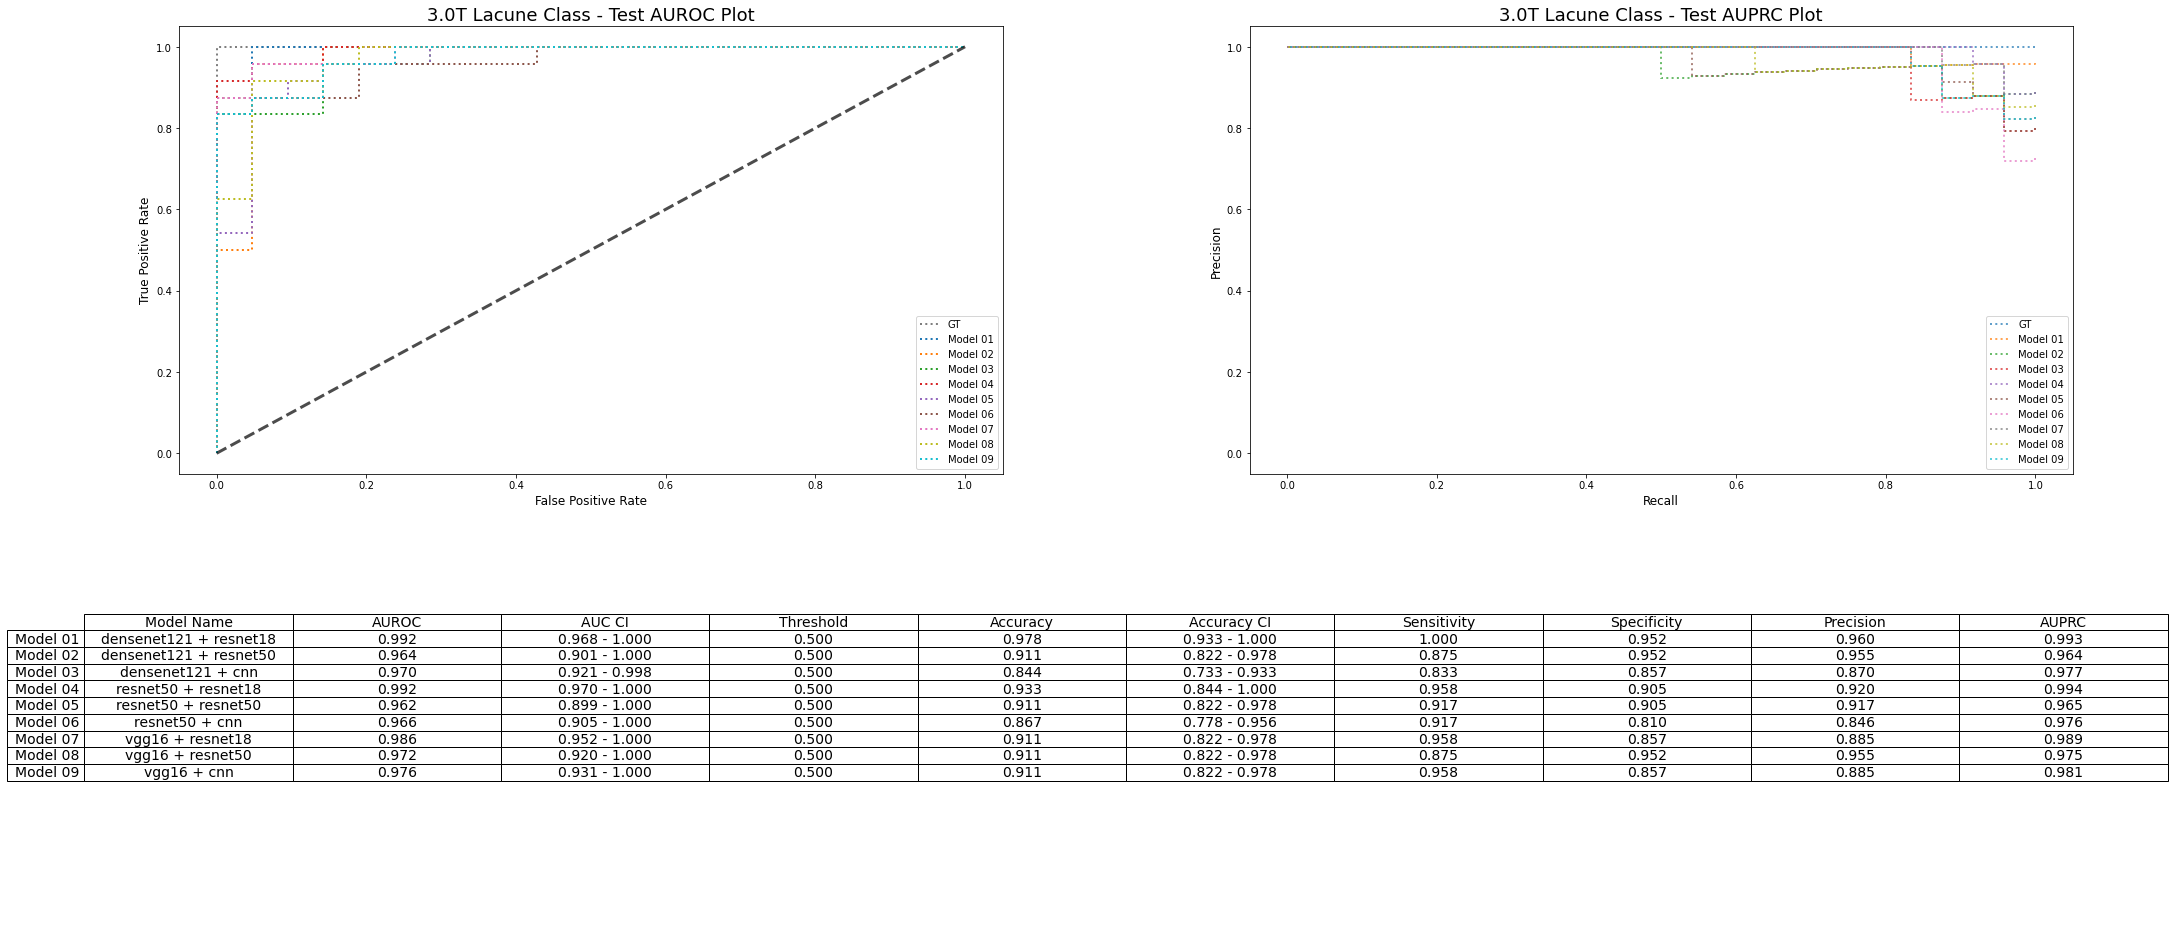

<Figure size 432x288 with 0 Axes>

In [15]:
fig = plt.figure(figsize=(30, 13))

grid = plt.GridSpec(nrows=2, ncols=2, figure=fig)
ax2 = plt.subplot(grid[0, 0])
ax3 = plt.subplot(grid[0, 1])
ax4 = plt.subplot(grid[1, 0:2])

y_flatten = S2_model_df['GT']
count=0
result_table1 = []
model_num = []
next_ = 0
optimal_th = 0.5

color = ['tab:gray','tab:blue','tab:orange','tab:green','tab:red','tab:purple',
         'tab:brown','tab:pink','tab:olive','tab:cyan','b','mediumvioletred']
d_style = ['X','+','H','*','s','4','^','v','o','D','p','d']

for i in S2_model_df:
    p_flatten = S2_model_df[i]
# -------------------------------plot AUROC and Cut-off Point-------------------
    auc = roc_auc_score(y_flatten, p_flatten)
    fpr, tpr, ths = roc_curve(y_flatten, p_flatten)
# -------------------------------plot AUPRC-----------------------------
    ap = average_precision_score(y_flatten, p_flatten)
    pre, rec, _ = precision_recall_curve(y_flatten, p_flatten)

    # ----table----
    if i=='GT':
        ax2.plot(fpr, tpr, lw=2, linestyle='dotted', color=color[count], label = f'GT')
        ax3.step(rec, pre, lw=2, linestyle='dotted', label = f'GT', alpha=0.7)
    elif i !='GT':
        if next_+1<10:
            model_ns = f'Model 0{next_+1}'
            model_num.append(model_ns)
        else:
            model_ns = f'Model {next_+1}'
            model_num.append(model_ns)
        ax2.plot(fpr, tpr, lw=2, linestyle='dotted', color=color[count], label = f'{model_ns}')
        ax3.step(rec, pre, lw=2, linestyle='dotted', label = f'{model_ns}', alpha=0.7)
        result_table1.append([i])
        p_flatten = S2_model_df[i]
        cl1,cu1 =CI(p_flatten, y_flatten, optimal_th, score_type='auc')

        cl2,cu2 =CI(p_flatten, y_flatten, optimal_th, score_type='acc')
        y_proba_th = ((p_flatten > optimal_th).astype(np.int8))
        acc = accuracy_score(y_flatten, y_proba_th)
        CM = confusion_matrix(y_flatten, y_proba_th)
        result_table1[next_].append(f'{auc:.3f}')
        result_table1[next_].append(f'{cl1:.3f} - {cu1:.3f}')
        result_table1[next_].append(f'{optimal_th:.3f}')
        result_table1[next_].append(f'{acc:.3f}')
        result_table1[next_].append(f'{cl2:.3f} - {cu2:.3f}')
        result_table1[next_].append(f'{(CM[1,1]/(CM[1,1]+CM[1,0])):.3f}')
        result_table1[next_].append(f'{(CM[0,0]/(CM[0,0]+CM[0,1])):.3f}')
        result_table1[next_].append(f'{(CM[1,1]/(CM[1,1]+CM[0,1])):.3f}')
        result_table1[next_].append(f'{ap:.3f}')
    # ----table----
        next_+=1
    count+=1

ax2.plot([0, 1], [0, 1], linestyle='--', lw=3, color='black', alpha=.7)
ax2.legend(fontsize=10, loc='lower right')
ax2.set_title(f'{datatype} Lacune Class - Test AUROC Plot', fontsize=18)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])

ax3.legend(fontsize=10, loc='lower right')
ax3.set_title(f'{datatype} Lacune Class - Test AUPRC Plot', fontsize=18)
ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_xlim([-0.05, 1.05])
ax3.set_ylim([-0.05, 1.05])


result_table1 = pd.DataFrame(result_table1, columns = ['Model Name', 'AUROC', 'AUC CI',
                                                        'Threshold', 'Accuracy', 'Accuracy CI',
                                                       'Sensitivity', 'Specificity', 'Precision','AUPRC'])

ax4.axis('off')
ax4.axis('tight')
tab1 = ax4.table(cellText=result_table1.values, rowLabels = model_num, colLabels=result_table1.columns, cellLoc='center',loc='center')
tab1.scale(1.1,1)
tab1.auto_set_font_size(False)
tab1.set_fontsize(14)

if not os.path.exists(save_path):
    os.makedirs(save_path)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0)
save_plt = './plot_results/'
if not os.path.exists(save_plt):
    os.makedirs(save_plt)
plt.savefig(save_plt + f'{datatype} Lacune ALL model - Curve Plot .png', dpi=100)
# plt.savefig(f'{save_path}/{datatype} Lacune ALL model - Curve Plot .jpg')
plt.show()
plt.clf()

In [17]:
# def heat_model(weight_path, backbone):
#     if 'resnet18' in backbone:
#         model = Resnet3DBuilder.build_resnet_18((32, nii_size, nii_size, 1), 1)
#     elif 'resnet50' in backbone:
#         model = Resnet3DBuilder.build_resnet_50((32, nii_size, nii_size, 1), 1)
#     elif 'cnn' in backbone:
#         model = get_model(depth=32, width=384, height=384, class_num=1, classification_layer='sigmoid')
     
#     model.load_weights(weight_path)
#     return model

In [18]:
# heatmap_weight=[S2_Resnet18, Only_ResNet50, Only_CNN]
# heatmap_backbone=['resnet18', 'resnet50', 'cnn']

In [19]:
# def last_conv_n(model_, backbone):
#     count=0
#     for i in model_.layers[::-1]:
#         print(i.name)
#         if 'cnn' in backbone:
#             if 'pooling' in i.name and list(i.output_shape)[1]==1:
#                 name = i.name
#                 return name
#                 break
#         if '18' in backbone:
#             # if 'conv' in i.name and count<1:
#             #     count+=1
#             # elif 'conv' in i.name and count==1:
#             if 'conv' in i.name:
#                 name = i.name
#                 return name
#                 break

#         elif '50' in backbone:
#             if 'add' in i.name:
#                 name = i.name
#                 return name
#                 break
    

In [20]:
# path_stack = ['T3_image_mask_path_valid.npy','T1_image_mask_path_valid.npy']
# path = np.load(top_layer_path + '/' + path_stack[data_n])

In [21]:
# sys.path.append("..")
# from utils.heat_utils_2 import heat_map
# from tqdm import tqdm
# # save all heatmap
# # all_heat = np.zeros((3,len(y_flatten), 384,384))
# heat1=[]
# heat2=[]
# heat3=[]

In [22]:
# import cv2
# from PIL import Image as im
# model1=heat_model(heatmap_weight[0],heatmap_backbone[0])
# conv_name = last_conv_n(model1, heatmap_backbone[0])
# X = S1_pred_stack[0]
# # print('test data shape', X.shape)
# for j in tqdm(range(len(y_flatten))):
#     img_name = path[j].replace('../isXXXX_all_mask_and_image_check/3.0T_test/', '').replace('../isXXXX_all_mask_and_image_check/1.5T_test/','')[:6]
#     hp = heat_map(model1, X[j]>0.5, y_flatten[j], img_name, 0.5, 'Circulation', conv_name)
#     hp = cv2.resize(hp, (384,384), interpolation=cv2.INTER_LANCZOS4)
#     hp = im.fromarray(hp)
#     heat1.append(np.array(hp))
#     # print(temp.shape)

In [23]:
# import nibabel as nib
# from skimage import morphology
# from scipy import ndimage
# from PIL import Image
# depth = 32
# def resize_volume(img, size = 384,depth = 32):
#     """Resize across z-axis"""
#     # Set the desired depth
#     current_depth = img.shape[-1]
#     current_width = img.shape[0]
#     current_height = img.shape[1]
#     img = ndimage.zoom(img, (size/current_height, size/current_width, 1), order=0)
#     return img

# def process_scan(path, size):
# # get nib first channel
#     image = nib.load(path)
#     affine = image.header.get_best_affine()

#     if len(image.shape) == 4:
#         image = image.get_fdata()
#         width,height,queue,_ = image.shape
#         image = image[:,:,:,1]
#         image = np.reshape(image,(width,height,queue))
#     else:
#         image = image.get_fdata()
#         pass
#     if affine[1, 1] > 0:
#         image = ndimage.rotate(image, 90, reshape=False, mode="nearest")
#     if affine[1, 1] < 0:
#         image = ndimage.rotate(image, -90, reshape=False, mode="nearest")
#     # print(affine)
#     volume = resize_volume(image,size,depth)
# #   add only black background mri image
#     if volume.shape[2]!=depth:
#         add_black_num = depth - volume.shape[2]
#         volume = volume.transpose(2,0,1)
#         for i in range(add_black_num):
#             add_black_ = np.expand_dims(np.zeros((volume.shape[2],volume.shape[2])),axis=0)
#             volume = np.concatenate((volume, add_black_), axis = 0)
#         volume = volume.transpose(1,2,0)
#     volume = volume.transpose(2,0,1)
#     if affine[0, 0] < 0:
#         for i in range(volume.shape[0]):
#             volume[i,:,:] = np.fliplr(volume[i,:,:])
#     return volume

In [24]:
# def get_original_mri(nii_name, valid_dtype):
#     # print(nii_name)
#     data_list = sorted(os.listdir(f'/ssd1/cnn/Classification/isXXXX_all_mask_and_image_check/{valid_dtype}_test'))
#     for i in data_list:
#         if nii_name in i and 'o' in i:
#             # print(i)
#             img = process_scan(f'/ssd1/cnn/Classification/isXXXX_all_mask_and_image_check/{valid_dtype}_test/'+i,384)
#             # print(img.shape)
#             return img


In [25]:
# import matplotlib.pyplot as pyplot
# label_list = ['No-Lacune', 'Lacune']
# # for p in range(1):

In [26]:
# from PIL import Image
# def fig2npy(fig):
#     fig.canvas.draw()
#     w,h = fig.canvas.get_width_height()
#     buf = np.frombuffer ( fig.canvas.tostring_argb(), dtype=np.uint8 )
#     buf.shape = ( w, h,4 )
#     buf = np.roll ( buf, 3, axis = 2 )
#     return buf
# def fig2img(fig):
#     buf = fig2npy(fig)
#     w, h, d  = buf.shape
#     return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

In [27]:
# def plot_results(p, orig_img, gt_label, img_name):
#     count=1
#     gif_arr = []
#     for i in range(32):
#         if np.sum(S1_X_valid[p][i])!=0:
#             fig, ax = plt.subplots(1,4, figsize = (13, 4))

#             ax1 = ax[0]
#             ax1.imshow(orig_img[i], cmap='gray')
#             ax1.set_title(f'GT Img-{img_name} {label_list[gt_label]}')
#             ax1.axis('off')

#             ax2 = ax[1]
#             ax2.imshow(S1_y_valid[p][i], cmap='gray')
#             ax2.set_title(f'GT Seg - {label_list[gt_label]}')
#             ax2.axis('off')

#             ax3 = ax[2]
#             ax3.imshow(S1_pred_stack[0][p][i]>.4, cmap='hot')
#             ax3.set_title(f'Pred S1 - {label_list[gt_label]} ')
#             ax3.axis('off')

#             ax4 = ax[3]
#             ax4.imshow(heat1[p], alpha=0.3, cmap='hot')
#             ax4.imshow(orig_img[i], alpha=0.5, cmap='gray')
#             ax4.set_title(f'Pred S1+S2 res18 - {label_list[gt_label]}')
#             ax4.axis('off')
#             fig.tight_layout()
#             plt.savefig(save_path + '/' + img_name+ '/' + f'{img_name}-{count}.jpg')

#             count+=1
#             im = fig2img(fig)
#             gif_arr.append(im)

#             plt.cla()
#             plt.clf()
#             plt.close()
#     im.save(save_path + '/' + img_name+ '/' + f'{img_name}.gif', save_all=True, append_images=[i for i in gif_arr], optimize=False, duration=500, loop=0)
#     del im
#     # ax.close('all')
    
    

In [28]:
# for p in tqdm(range(S1_X_valid.shape[0])):
# # for p in tqdm(range(1):
#     gt_label = y_flatten[p]

#     img_name = path[p].replace('../isXXXX_all_mask_and_image_check/3.0T_test/', '').replace('../isXXXX_all_mask_and_image_check/1.5T_test/','')[:6]
#     orig_img = get_original_mri(img_name, datatype)
#      # heatmap [GT, Seg, pred1, S2 res18 h, only res50 h, only cnn h ]
#     if not os.path.exists(save_path + '/' + img_name):
#         os.makedirs(save_path + '/' + img_name)
#     plot_results(p, orig_img ,gt_label, img_name)
    
